In [326]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from statsmodels.stats.multitest import multipletests

# Define experiments

In [87]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
]
}

experiment_ids = ["rpl22_oe","rpl22l1_oe","sh704","sh705"]

# Load TPMS and sleuth results

In [102]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_genes.txt", sep="\t", index_col=0)
rpl22l1_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_genes.txt", sep="\t", index_col=0)
sh704_genes = pd.read_csv(kallisto_sleuth_path + "sh704_genes.txt", sep="\t", index_col=0)
sh705_genes = pd.read_csv(kallisto_sleuth_path + "sh705_genes.txt", sep="\t", index_col=0)

rpl22_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_transcripts.txt", sep="\t", index_col=0)
rpl22l1_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_transcripts.txt", sep="\t", index_col=0)
sh704_transcripts = pd.read_csv(kallisto_sleuth_path + "sh704_transcripts.txt", sep="\t", index_col=0)
sh705_transcripts = pd.read_csv(kallisto_sleuth_path + "sh705_transcripts.txt", sep="\t", index_col=0)

# Differential expression

In [103]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

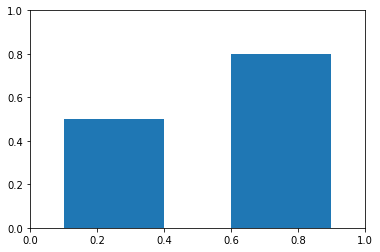

In [333]:
ax = plt.subplot(111)

control_rect = Rectangle([0.1,0],0.3,0.5)
ax.add_patch(control_rect)

treatment_rect = Rectangle([0.6,0],0.3,0.8)
ax.add_patch(treatment_rect)

plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x1a53081a10>, 9.284031840259944)

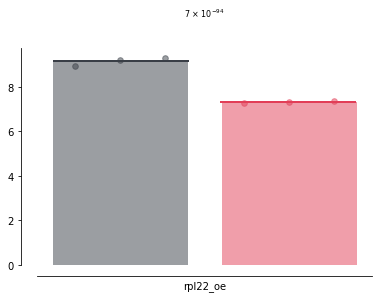

In [370]:
bars("ENSG00000163584",
              "rpl22_oe",
              rpl22_oe_genes,
              ylabel="")

In [383]:
control_color = "#393e46"
treatment_color = "#e23e57"
alpha = 0.5


def bars(transcript_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[transcript_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    control_tpms = np.log2(select_abundance[controls].astype(np.float64)+1)
    treatment_tpms = np.log2(select_abundance[treatments].astype(np.float64)+1)

    control_mean = np.mean(control_tpms)
    treatment_mean = np.mean(treatment_tpms)

    offset = 0.05
    width = 0.4

    control_rect = Rectangle([offset, 0],
                             width,
                             control_mean,
                             color=control_color,
                             alpha=alpha,
                             linewidth=0
                             )
    ax.add_patch(control_rect)

    treatment_rect = Rectangle([0.5+offset, 0],
                               width,
                               treatment_mean,
                               color=treatment_color,
                               alpha=alpha,
                               linewidth=0)
    ax.add_patch(treatment_rect)
    
    ax.scatter([0.25-width/3,0.25,0.25+width/3], 
               control_tpms,
               color=control_color,
               linewidth=1,
               s=32,
#                alpha=alpha,
               edgecolor="black"
              )
    ax.scatter([0.75-width/3,0.75,0.75+width/3], 
               treatment_tpms,
               color=treatment_color,
               linewidth=1,
               s=32,
#                alpha=alpha,
               edgecolor="black"
              )

    ax.axhline(control_mean, offset, offset+width,
               linewidth=2, color=control_color, zorder=0)
    ax.axhline(treatment_mean, 0.5+offset, 0.5+offset+width,
               linewidth=2, color=treatment_color, zorder=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.025))
    ax.spines['left'].set_position(('axes', -0.05))

    plt.ylim(0)

    y_max = max(list(control_tpms)+list(treatment_tpms))

    if not np.isnan(select_abundance["qval"]):

        qval = as_si(select_abundance["qval"], 0)
        ax.text(0.5, y_max*1.2, qval, ha="center", fontsize=8)

    return ax, y_max


def plot_tpm_dist_all(annotation_id, annotation_type):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(4.5, 3))

    maxes = []

    if annotation_type == "transcript":

        sleuth_sets = [rpl22_oe_transcripts,
                       rpl22l1_oe_transcripts,
                       sh704_transcripts,
                       sh705_transcripts
                       ]

    elif annotation_type == "gene":

        sleuth_sets = [rpl22_oe_genes,
                       rpl22l1_oe_genes,
                       sh704_genes,
                       sh705_genes
                       ]

    for sleuth_idx, sleuth_set in enumerate(sleuth_sets):
        ax = axes[sleuth_idx]

        ax, y_max = bars(annotation_id,
                                  experiment_ids[sleuth_idx],
                                  sleuth_set,
                                  ax=ax,
                                  ylabel="")

        maxes.append(y_max)

        if sleuth_idx > 0:

            ax.spines["left"].set_visible(False)
            ax.tick_params(axis='y', which='both', right=False,
                           left=False, labelleft=False)

    axes[0].set_xlabel("RPL22++")
    axes[1].set_xlabel("RPL22L1++")
    axes[2].set_xlabel("shRPL22L1_1")
    axes[3].set_xlabel("shRPL22L1_2")

    axes[0].set_ylabel("mRNA expression, log2(TPM+1)")

    plt.ylim(0, max(maxes)*1.25)

    plt.subplots_adjust(wspace=0.25)

    legend_background = "#eaeaea"

    legend_elements = [Patch(label='Control',
                             color=control_color, alpha=alpha),
                       Patch(label='Treatment',
                             color=treatment_color, alpha=alpha)]

    legend = plt.legend(handles=legend_elements,
                        loc='upper left', bbox_to_anchor=(1, 1),)
    frame = legend.get_frame()
    frame.set_facecolor(legend_background)
    frame.set_edgecolor(legend_background)

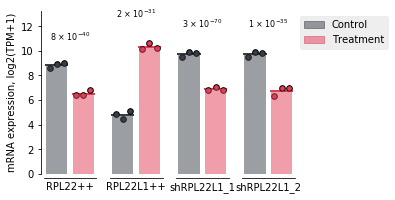

In [384]:
plot_tpm_dist_all("ENST00000463836","transcript")


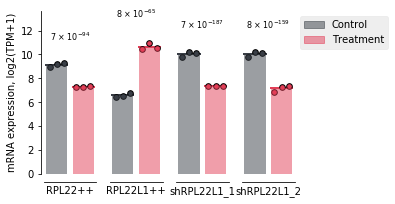

In [380]:
plot_tpm_dist_all("ENSG00000163584","gene")

plt.savefig("../plots/rpl22l1_ENSG00000163584_expression.pdf",bbox_inches="tight",background="transparent")

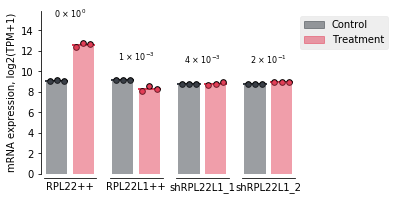

In [385]:
plot_tpm_dist_all("ENSG00000116251","gene")

plt.savefig("../plots/rpl22_ENSG00000116251_expression.pdf",bbox_inches="tight",background="transparent")

## Volcano plots

In [96]:
def compute_medians(sleuth_diff, experiment):
    sleuth_diff["control_median"] = sleuth_diff[experiments[experiment][0]].median(axis=1)
    sleuth_diff["treatment_median"] = sleuth_diff[experiments[experiment][1]].median(axis=1)
    sleuth_diff["median_foldchange"] = sleuth_diff["treatment_median"]/sleuth_diff["control_median"]

In [122]:
compute_medians(rpl22_oe_genes,"rpl22_oe")
compute_medians(rpl22l1_oe_genes,"rpl22l1_oe")
compute_medians(sh704_genes,"sh704")
compute_medians(sh705_genes,"sh705")

compute_medians(rpl22_oe_transcripts,"rpl22_oe")
compute_medians(rpl22l1_oe_transcripts,"rpl22l1_oe")
compute_medians(sh704_transcripts,"sh704")
compute_medians(sh705_transcripts,"sh705")

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


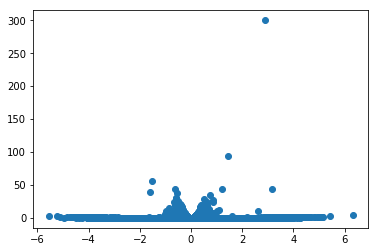

In [136]:
sleuth_diff = rpl22_oe_transcripts

plt.scatter(sleuth_diff["b"],-np.log10(sleuth_diff["qval"]+10**(-300)))

# plt.xlim(-5,5)

# Differential splicing

In [26]:
rpl22_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_oe.txt",sep="\t")
rpl22l1_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_oe.txt",sep="\t")
sh704_rmats = pd.read_csv("../data/processed/rmats_merge/sh704.txt",sep="\t")
sh705_rmats = pd.read_csv("../data/processed/rmats_merge/sh705.txt",sep="\t")

In [27]:
def plot_psi_dist(exon_id, experiment_id, diff_results, ax=None, pal=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if pal is None:
        pal = sns.color_palette([control_color, treatment_color])

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"

    select_abundance = diff_results.loc[exon_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    tpms = np.log2(select_abundance[controls+treatments].astype(np.float64)+1)

    expression_df = pd.DataFrame(index=controls+treatments)

    expression_df["tpm"] = tpms
    expression_df["treatment"] = ["control"] * \
        len(controls)+["treatment"]*len(treatments)

    sns.swarmplot(x="treatment",
                  y="tpm",
                  data=expression_df,
                  ax=ax,
                  palette=pal,
                  s=6,
                  alpha=alpha,
                  linewidth=1,
                  edgecolor="black",
                  )
    
    means = expression_df.groupby("treatment")["tpm"].mean()
    
    ax.axhline(means["control"], 0.15,0.35, linewidth=2, color="black", zorder=100)
    ax.axhline(means["treatment"], 0.65,0.85, linewidth=2, color="black", zorder=100)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    plt.ylim(0)
    
    y_max = max(tpms)
    
    if not np.isnan(select_abundance["qval"]):
    
        qval = as_si(select_abundance["qval"],0)
        ax.text(0.5, y_max*1.2, qval,ha="center",fontsize=8)

    return ax, y_max


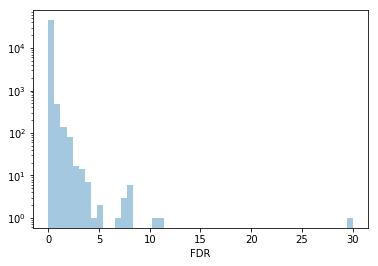

In [141]:
sns.distplot(-np.log10(rpl22_oe_rmats["FDR"]+10**(-30)),kde=False)
plt.yscale("log")

In [145]:
sh704_genes.head()

,target_id,ext_gene,duplicate_transcript,num_aggregated_transcripts,sum_mean_obs_counts,pval,qval,LNCaP_shLuc_1,LNCaP_shLuc_2,LNCaP_shLuc_3,LNCaP_sh704_1,LNCaP_sh704_2,LNCaP_sh704_3,control_median,treatment_median,median_foldchange
ENSG00000005513,1,SOX8,False,2.0,10.968773,1.160364e-252,1.951153e-248,5.295105,4.851195,4.756822,57.048750,59.529240,52.131820,4.851195,57.048750,11.759731
ENSG00000163584,2,RPL22L1,False,4.0,21.855229,8.229427e-191,6.918891e-187,891.159020,1150.300965,1125.603910,162.435300,164.608800,158.170470,1125.603910,162.435300,0.144309
ENSG00000124762,3,CDKN1A,False,5.0,21.492522,5.696871e-177,3.193096e-173,115.298309,118.203447,116.923240,506.216740,503.893448,466.437523,116.923240,503.893448,4.309609
ENSG00000115414,4,FN1,False,18.0,72.418226,1.295350e-176,5.445329e-173,135.805285,122.463850,111.764645,377.147100,350.762155,398.952128,122.463850,377.147100,3.079661
ENSG00000080546,5,SESN1,False,6.0,26.100638,4.211762e-149,1.416416e-145,62.272119,75.895400,51.547618,224.421851,225.848030,209.980600,62.272119,224.421851,3.603890


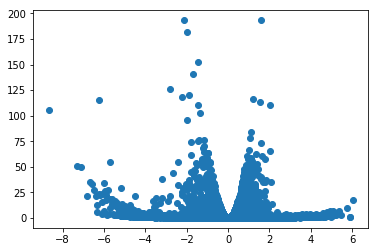

In [148]:
plt.scatter(sh705_transcripts["b"],-np.log10(sh705_transcripts["qval"]))